In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

# Попытка импортировать Prophet
try:
    from prophet import Prophet
except ImportError:
    print("Библиотека Prophet не установлена. Для ее использования выполните: pip install prophet")
    Prophet = None

In [ ]:
class TimeSeriesPredictor:
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = None
        self.time_column = None
        self.value_column = None
        self.is_seasonal = False
        self.seasonal_period = None

    def load_data(self, time_column_name=None, value_column_name=None):
        """
        Загружает данные из CSV файла и подготавливает их.
        Предполагается, что данные имеют временной столбец и столбец значений.
        """
        try:
            self.df = pd.read_csv(self.filepath)
            print(f"Данные успешно загружены из: {self.filepath}")
            print("Первые 5 строк данных:")
            print(self.df.head())

            # Попытка автоматического определения столбцов
            if not time_column_name:
                # Ищем столбец, который можно преобразовать в datetime
                for col in self.df.columns:
                    try:
                        self.df[col] = pd.to_datetime(self.df[col])
                        self.time_column = col
                        break
                    except (ValueError, TypeError):
                        pass
                if not self.time_column:
                    raise ValueError("Не удалось автоматически определить временной столбец. Укажите его явно.")
            else:
                self.df[time_column_name] = pd.to_datetime(self.df[time_column_name])
                self.time_column = time_column_name

            if not value_column_name:
                # Ищем числовой столбец, который не является временным
                numeric_cols = self.df.select_dtypes(include=np.number).columns.tolist()
                numeric_cols = [col for col in numeric_cols if col != self.time_column]
                if not numeric_cols:
                    raise ValueError("Не удалось автоматически определить столбец значений. Укажите его явно.")
                elif len(numeric_cols) > 1:
                    print(f"Обнаружено несколько числовых столбцов: {numeric_cols}. Использую первый: {numeric_cols[0]}.")
                    self.value_column = numeric_cols[0]
                else:
                    self.value_column = numeric_cols[0]
            else:
                self.value_column = value_column_name

            self.df = self.df[[self.time_column, self.value_column]].set_index(self.time_column).sort_index()
            print(f"Используемый временной столбец: '{self.time_column}'")
            print(f"Используемый столбец значений: '{self.value_column}'")
            print("\nИнформация о DataFrame после обработки:")
            self.df.info()
            print("\nСтатистика по столбцу значений:")
            print(self.df[self.value_column].describe())

        except Exception as e:
            print(f"Ошибка при загрузке или обработке данных: {e}")
            self.df = None

    def plot_time_series(self, title="Временной ряд"):
        """Визуализирует временной ряд."""
        if self.df is None:
            print("Данные не загружены.")
            return

        plt.figure(figsize=(15, 6))
        plt.plot(self.df.index, self.df[self.value_column], label=self.value_column)
        plt.title(title)
        plt.xlabel("Дата")
        plt.ylabel("Значение")
        plt.legend()
        plt.grid(True)
        plt.show()
        # [Image of a time series plot with date on x-axis and value on y-axis]

    def check_for_seasonality_and_trend(self):
        """
        Проверяет наличие сезонности и тренда, используя разложение временного ряда и тест Дики-Фуллера.
        """
        if self.df is None:
            print("Данные не загружены.")
            return

        print("\n--- Проверка на сезонность и тренд ---")

        # Проверка на пропуски
        if self.df[self.value_column].isnull().any():
            print("В данных обнаружены пропуски. Рекомендуется их обработать (например, интерполяцией).")
            # Пример простой интерполяции:
            self.df[self.value_column] = self.df[self.value_column].interpolate(method='time')
            print("Пропуски интерполированы.")


        # Тест Дики-Фуллера для проверки стационарности (наличия тренда)
        try:
            result = adfuller(self.df[self.value_column].dropna())
            print(f"ADF Statistic: {result[0]}")
            print(f"p-value: {result[1]}")
            print("Critical Values:")
            for key, value in result[4].items():
                print(f"\t{key}: {value}")

            if result[1] > 0.05:
                print("Временной ряд нестационарен (вероятно, присутствует тренд).")
            else:
                print("Временной ряд стационарен (тренд не выражен).")
        except Exception as e:
            print(f"Ошибка при выполнении теста Дики-Фуллера: {e}")


        # Разложение временного ряда
        # Попытка определить частоту (period)
        freq_str = pd.infer_freq(self.df.index)
        print(f"Предполагаемая частота данных: {freq_str}")

        # Попытка определить сезонный период
        # Для дневных данных: 7 (неделя), 30/31 (месяц), 365 (год)
        # Для месячных: 12 (год)
        # Пробуем несколько периодов и смотрим на результат разложения
        possible_periods = []
        if freq_str and 'D' in freq_str: # Если дневные данные
            possible_periods = [7, 30, 365]
        elif freq_str and 'M' in freq_str: # Если месячные данные
            possible_periods = [12]
        elif freq_str and 'H' in freq_str: # Если часовые данные
            possible_periods = [24, 24*7] # Ежедневная, еженедельная

        print(f"Попытка разложения с периодами: {possible_periods}")
        decomposition_successful = False
        for period in possible_periods:
            if len(self.df) > 2 * period: # Должно быть достаточно данных для разложения
                try:
                    # Попытка аддитивной модели
                    decomposition = seasonal_decompose(self.df[self.value_column].dropna(), model='additive', period=period)
                    decomposition.plot().set_size_inches(10, 8)
                    plt.suptitle(f"Разложение временного ряда (Аддитивная модель, период={period})", y=1.02)
                    plt.tight_layout(rect=[0, 0, 1, 0.98])
                    plt.show()
                    # [Image of seasonal decomposition plot showing original, trend, seasonal, and residual components]

                    # Попытка мультипликативной модели (если значения положительны)
                    if (self.df[self.value_column] > 0).all():
                        decomposition = seasonal_decompose(self.df[self.value_column].dropna(), model='multiplicative', period=period)
                        decomposition.plot().set_size_inches(10, 8)
                        plt.suptitle(f"Разложение временного ряда (Мультипликативная модель, период={period})", y=1.02)
                        plt.tight_layout(rect=[0, 0, 1, 0.98])
                        plt.show()
                        # [Image of seasonal decomposition plot showing original, trend, seasonal, and residual components]
                    decomposition_successful = True
                    self.is_seasonal = True
                    self.seasonal_period = period
                    print(f"Сезонность предположительно присутствует с периодом: {period}")
                    break # Останавливаемся на первом успешном разложении
                except Exception as e:
                    # print(f"Не удалось выполнить разложение с периодом {period}: {e}")
                    pass # Пробуем следующий период

        if not decomposition_successful:
            print("Не удалось однозначно определить сезонность с помощью разложения. Возможно, сезонность отсутствует или данные недостаточны.")
            self.is_seasonal = False

        # ACF и PACF
        # Используем diff, если есть тренд, чтобы сделать ряд стационарным для ACF/PACF
        if result[1] > 0.05: # Если нестационарный
            diff_series = self.df[self.value_column].diff().dropna()
            print("\nACF и PACF для дифференцированного ряда (для определения порядков ARIMA):")
        else:
            diff_series = self.df[self.value_column].dropna()
            print("\nACF и PACF для исходного ряда (для определения порядков ARIMA):")

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        plot_acf(diff_series, ax=axes[0], lags=min(40, len(diff_series)//2 -1))
        axes[0].set_title('Autocorrelation Function (ACF)')
        plot_pacf(diff_series, ax=axes[1], lags=min(40, len(diff_series)//2 -1))
        axes[1].set_title('Partial Autocorrelation Function (PACF)')
        plt.show()
        # [Image of ACF plot]
        # [Image of PACF plot]
        print("Посмотрите на графики ACF и PACF для определения потенциальных порядков p, d, q (для ARIMA) и P, D, Q, S (для SARIMA).")
        print("Значимые всплески на ACF указывают на порядок MA (q), на PACF - на порядок AR (p).")
        print("Периодические всплески на ACF/PACF могут указывать на сезонность.")


    def train_and_predict(self, forecast_horizon, model_type="auto",
                          order=(5,1,0), seasonal_order=(1,1,0,12),
                          holtwinter_trend='add', holtwinter_seasonal='add', holtwinter_seasonal_period=None):
        """
        Обучает выбранную модель и делает прогноз.
        :param forecast_horizon: Длина горизонта прогнозирования.
        :param model_type: Тип модели ('auto', 'arima', 'sarima', 'holt_winters', 'prophet').
        :param order: Порядок (p,d,q) для ARIMA/SARIMA.
        :param seasonal_order: Сезонный порядок (P,D,Q,S) для SARIMA.
        :param holtwinter_trend: Тип тренда для Хольта-Уинтерса ('add', 'mul', 'add_damped', 'mul_damped', 'None').
        :param holtwinter_seasonal: Тип сезонности для Хольта-Уинтерса ('add', 'mul', 'None').
        :param holtwinter_seasonal_period: Период сезонности для Хольта-Уинтерса.
        :return: DataFrame с прогнозом.
        """
        if self.df is None:
            print("Данные не загружены.")
            return None

        print(f"\n--- Прогнозирование с использованием {model_type} ---")

        # Разделение на обучающую и тестовую выборки (для оценки, если горизонт не весь ряд)
        train_size = int(len(self.df) * 0.8) # 80% на обучение, 20% на тест
        train_data = self.df[self.value_column].iloc[:train_size]
        test_data = self.df[self.value_column].iloc[train_size:]

        forecast_index = pd.date_range(start=self.df.index[-1], periods=forecast_horizon + 1, freq=pd.infer_freq(self.df.index))[1:]

        model = None
        forecast = None
        model_name = ""

        if model_type == "auto":
            if self.is_seasonal and self.seasonal_period:
                model_type = "sarima"
                print(f"Автоматически выбрана модель SARIMA из-за обнаруженной сезонности (период: {self.seasonal_period}).")
            else:
                model_type = "arima"
                print("Автоматически выбрана модель ARIMA (сезонность не обнаружена).")

        if model_type == "arima":
            try:
                model_name = "ARIMA"
                model = ARIMA(train_data, order=order)
                model_fit = model.fit()
                print(model_fit.summary())
                forecast = model_fit.predict(start=len(train_data), end=len(train_data) + forecast_horizon - 1)
                forecast.index = forecast_index
            except Exception as e:
                print(f"Ошибка при обучении модели ARIMA: {e}")
                return None
        elif model_type == "sarima":
            if not self.is_seasonal or not self.seasonal_period:
                print("Для SARIMA требуется сезонность. Пожалуйста, запустите `check_for_seasonality_and_trend` сначала.")
                # Если период не определен, используем дефолтный или тот, что в seasonal_order
                if not self.seasonal_period:
                    self.seasonal_period = seasonal_order[3] if len(seasonal_order) == 4 else 12 # Дефолт 12
                print(f"Используется сезонный период: {self.seasonal_period}")
            try:
                model_name = "SARIMA"
                # Используем seasonal_order с определенным периодом
                seasonal_order_used = (seasonal_order[0], seasonal_order[1], seasonal_order[2], self.seasonal_period if self.seasonal_period else seasonal_order[3])
                print(f"Порядок SARIMA: {order}, Сезонный порядок: {seasonal_order_used}")
                model = ARIMA(train_data, order=order, seasonal_order=seasonal_order_used)
                model_fit = model.fit()
                print(model_fit.summary())
                forecast = model_fit.predict(start=len(train_data), end=len(train_data) + forecast_horizon - 1)
                forecast.index = forecast_index
            except Exception as e:
                print(f"Ошибка при обучении модели SARIMA: {e}")
                return None
        elif model_type == "holt_winters":
            try:
                model_name = "Хольта-Уинтерса"
                if not holtwinter_seasonal_period:
                    holtwinter_seasonal_period = self.seasonal_period if self.seasonal_period else 12 # Дефолт 12
                    print(f"Используется сезонный период Хольта-Уинтерса: {holtwinter_seasonal_period}")

                model = ExponentialSmoothing(train_data,
                                             trend=holtwinter_trend,
                                             seasonal=holtwinter_seasonal,
                                             seasonal_periods=holtwinter_seasonal_period)
                model_fit = model.fit()
                print(model_fit.summary())
                forecast = model_fit.forecast(forecast_horizon)
                forecast.index = forecast_index
            except Exception as e:
                print(f"Ошибка при обучении модели Хольта-Уинтерса: {e}")
                return None
        elif model_type == "prophet":
            if Prophet is None:
                print("Prophet не установлен. Пожалуйста, установите его (pip install prophet) или выберите другую модель.")
                return None
            try:
                model_name = "Prophet"
                prophet_df = train_data.reset_index()
                prophet_df.columns = ['ds', 'y'] # Prophet требует столбцы 'ds' (datetime) и 'y' (value)

                model = Prophet()
                # Можно добавить настройки для сезонности, тренда и праздников при необходимости
                # model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
                model.fit(prophet_df)

                future = model.make_future_dataframe(periods=forecast_horizon)
                prophet_forecast = model.predict(future)
                forecast = prophet_forecast['yhat'].iloc[-forecast_horizon:]
                forecast.index = forecast_index # Убеждаемся, что индекс совпадает

                fig = model.plot(prophet_forecast)
                plt.title(f"Прогноз с помощью Prophet (Horizon: {forecast_horizon})")
                plt.xlabel("Дата")
                plt.ylabel("Значение")
                plt.show()
                # [Image of Prophet forecast plot showing original data, forecast, and uncertainty intervals]

                fig2 = model.plot_components(prophet_forecast)
                plt.title("Компоненты Prophet (Тренд, Сезонность)")
                plt.show()
                # [Image of Prophet components plot showing trend, yearly seasonality, and weekly seasonality]

            except Exception as e:
                print(f"Ошибка при обучении модели Prophet: {e}")
                return None
        else:
            print(f"Неизвестный тип модели: {model_type}")
            return None

        if forecast is not None:
            forecast_df = pd.DataFrame({'Прогноз': forecast.values}, index=forecast.index)

            # Оценка качества на тестовых данных (если они есть)
            if len(test_data) > 0:
                # Обрезаем прогноз до длины тестовых данных для оценки
                # Если горизонт прогноза выходит за рамки тестовых данных, оцениваем только часть
                actual_values = test_data.head(forecast_horizon)
                predicted_values = forecast.head(len(actual_values))

                if len(actual_values) > 0:
                    mae = mean_absolute_error(actual_values, predicted_values)
                    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
                    print(f"\n--- Оценка качества для модели {model_name} ---")
                    print(f"MAE (Mean Absolute Error): {mae:.2f}")
                    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

            print(f"\nПрогноз на горизонт {forecast_horizon}:")
            print(forecast_df)

            # Визуализация фактических данных и прогноза
            plt.figure(figsize=(15, 7))
            plt.plot(self.df.index, self.df[self.value_column], label='Фактические данные')
            plt.plot(train_data.index, train_data, label='Обучающая выборка', color='blue', linestyle='--')
            if len(test_data) > 0:
                 plt.plot(test_data.index, test_data, label='Тестовая выборка', color='orange', linestyle='--')
            plt.plot(forecast_df.index, forecast_df['Прогноз'], label=f'Прогноз {model_name}', color='red', linestyle='--')
            plt.title(f"Фактические данные и прогноз ({model_name})")
            plt.xlabel("Дата")
            plt.ylabel("Значение")
            plt.legend()
            plt.grid(True)
            plt.show()
            # [Image of time series plot showing historical data and future forecast]

            return forecast_df
        return None

Данные успешно загружены из: sample_time_series.csv
Первые 5 строк данных:
              datesold   price
0  2007-02-07 00:00:00  525000
1  2007-02-27 00:00:00  290000
2  2007-03-07 00:00:00  328000
3  2007-03-09 00:00:00  380000
4  2007-03-21 00:00:00  310000
Используемый временной столбец: 'datesold'
Используемый столбец значений: 'price'

Информация о DataFrame после обработки:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29580 entries, 2007-02-07 to 2019-07-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   29580 non-null  int64
dtypes: int64(1)
memory usage: 462.2 KB

Статистика по столбцу значений:
count    2.958000e+04
mean     6.097363e+05
std      2.817079e+05
min      5.650000e+04
25%      4.400000e+05
50%      5.500000e+05
75%      7.050000e+05
max      8.000000e+06
Name: price, dtype: float64


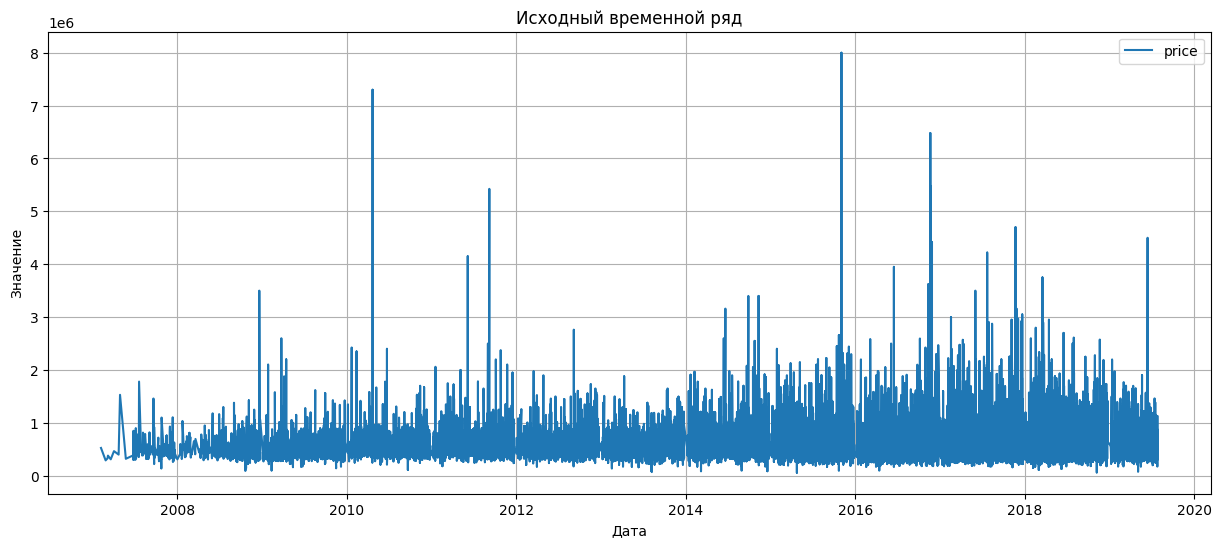


--- Проверка на сезонность и тренд ---
ADF Statistic: -20.075873699701695
p-value: 0.0
Critical Values:
	1%: -3.4305714127499476
	5%: -2.8616378583942694
	10%: -2.566822087046791
Временной ряд стационарен (тренд не выражен).
Предполагаемая частота данных: None
Попытка разложения с периодами: []
Не удалось однозначно определить сезонность с помощью разложения. Возможно, сезонность отсутствует или данные недостаточны.

ACF и PACF для исходного ряда (для определения порядков ARIMA):


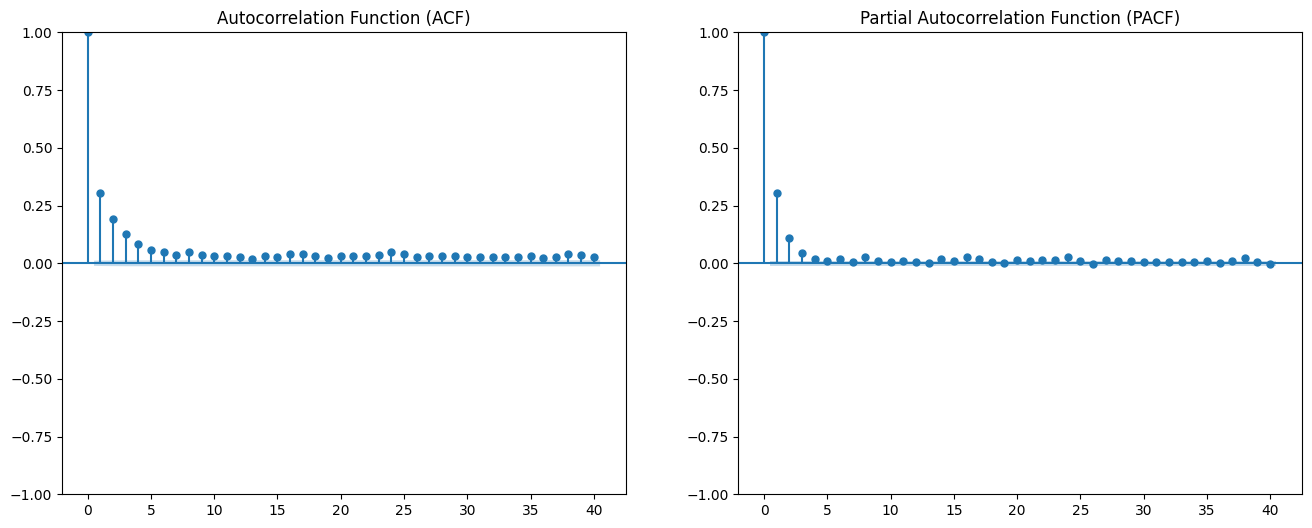

Посмотрите на графики ACF и PACF для определения потенциальных порядков p, d, q (для ARIMA) и P, D, Q, S (для SARIMA).
Значимые всплески на ACF указывают на порядок MA (q), на PACF - на порядок AR (p).
Периодические всплески на ACF/PACF могут указывать на сезонность.

--- Сезонность не обнаружена, SARIMA не будет использоваться ---

--- Пробуем Модель Хольта-Уинтерса ---

--- Прогнозирование с использованием holt_winters ---
Используется сезонный период Хольта-Уинтерса: 12
                        ExponentialSmoothing Model Results                        
Dep. Variable:                    price   No. Observations:                  23664
Model:             ExponentialSmoothing   SSE                 1745390178896781.500
Optimized:                         True   AIC                           592200.985
Trend:                         Additive   BIC                           592330.133
Seasonal:                      Additive   AICC                          592201.014
Seasonal Periods:       

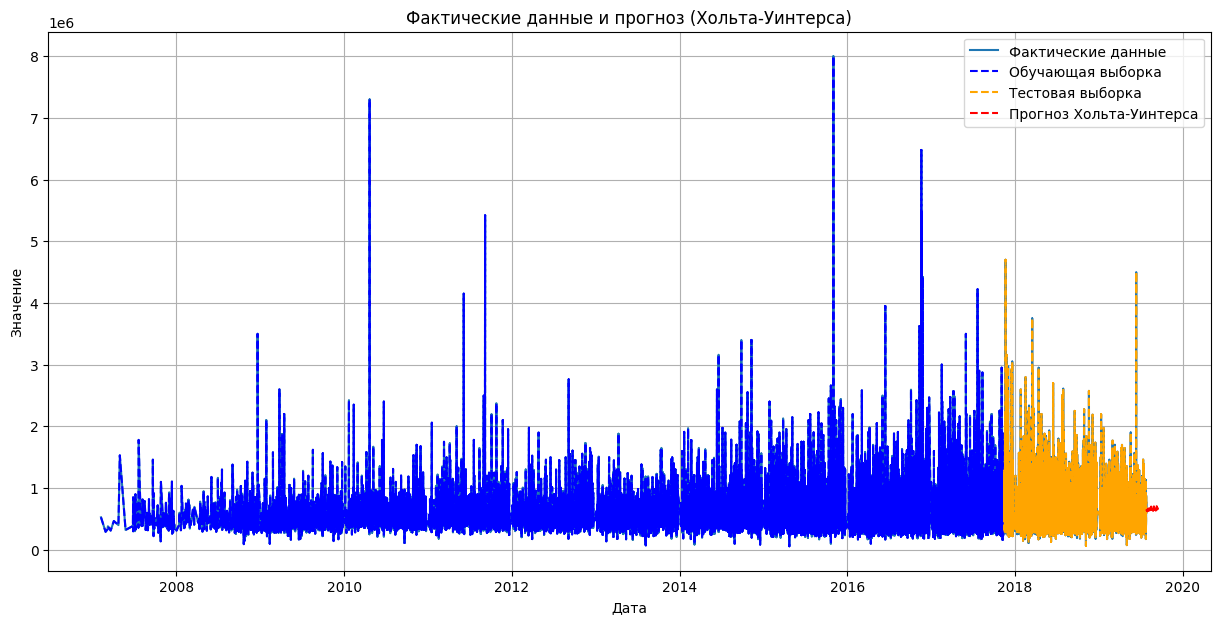

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptekgfk00/nkykxsdl.json



--- Пробуем Prophet ---

--- Прогнозирование с использованием prophet ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmptekgfk00/6h1w36ms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9902', 'data', 'file=/tmp/tmptekgfk00/nkykxsdl.json', 'init=/tmp/tmptekgfk00/6h1w36ms.json', 'output', 'file=/tmp/tmptekgfk00/prophet_modelcecfcwhz/prophet_model-20250609184518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


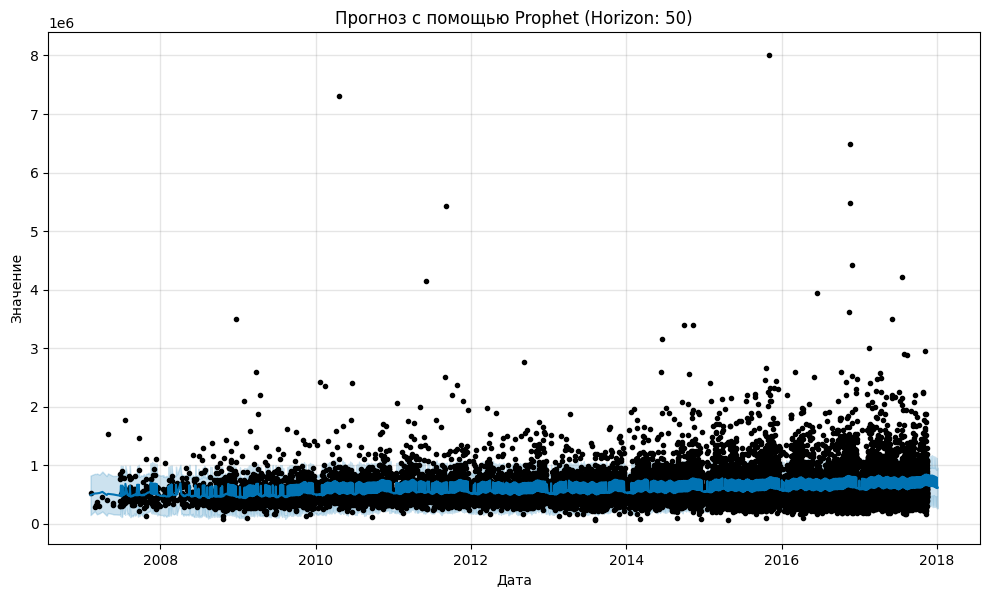

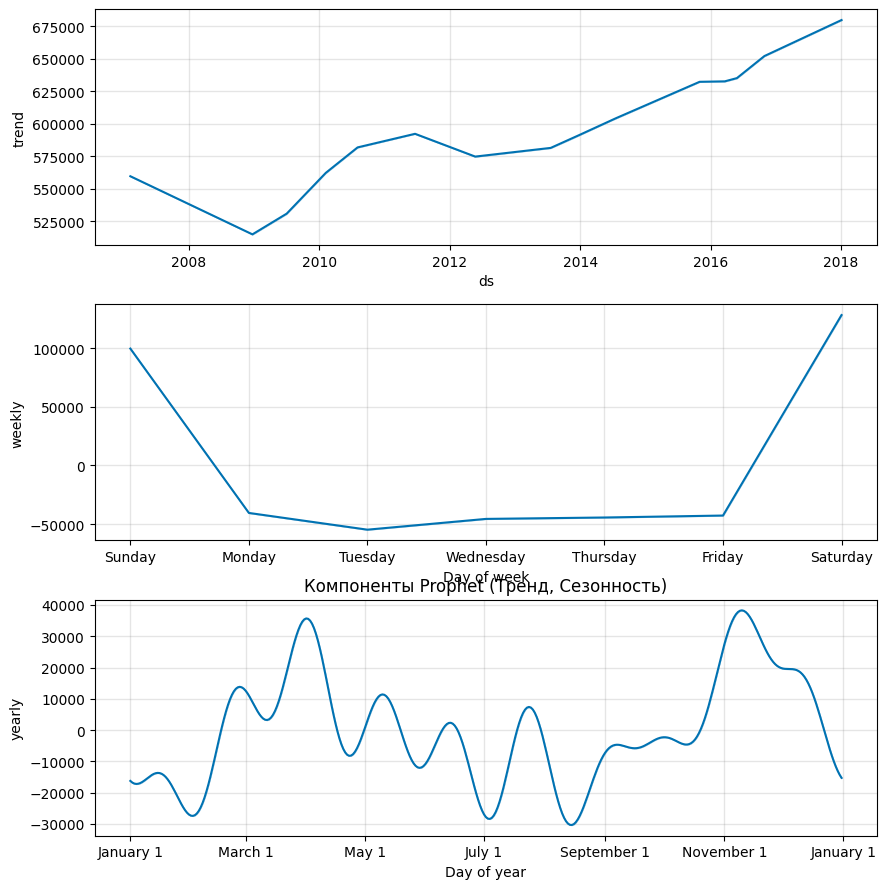


--- Оценка качества для модели Prophet ---
MAE (Mean Absolute Error): 201999.09
RMSE (Root Mean Squared Error): 254820.69

Прогноз на горизонт 50:
                  Прогноз
2019-07-28  666231.400082
2019-07-29  666677.295972
2019-07-30  836484.267602
2019-07-31  806531.373368
2019-08-01  664943.310420
2019-08-02  649360.735279
2019-08-03  657319.675187
2019-08-04  657373.381649
2019-08-05  658006.520794
2019-08-06  828201.166624
2019-08-07  798810.562099
2019-08-08  657928.813620
2019-08-09  643162.172403
2019-08-10  652009.519468
2019-08-11  652985.373393
2019-08-12  654535.280600
2019-08-13  825603.017943
2019-08-14  797005.535907
2019-08-15  656803.772056
2019-08-16  642574.954172
2019-08-17  651793.978645
2019-08-18  652957.155894
2019-08-19  654498.159958
2019-08-20  825355.594725
2019-08-21  796348.093737
2019-08-22  655545.078149
2019-08-23  640538.793640
2019-08-24  648825.219638
2019-08-25  648927.156682
2019-08-26  649309.348860
2019-08-27  818945.078858
2019-08-28  788690.1

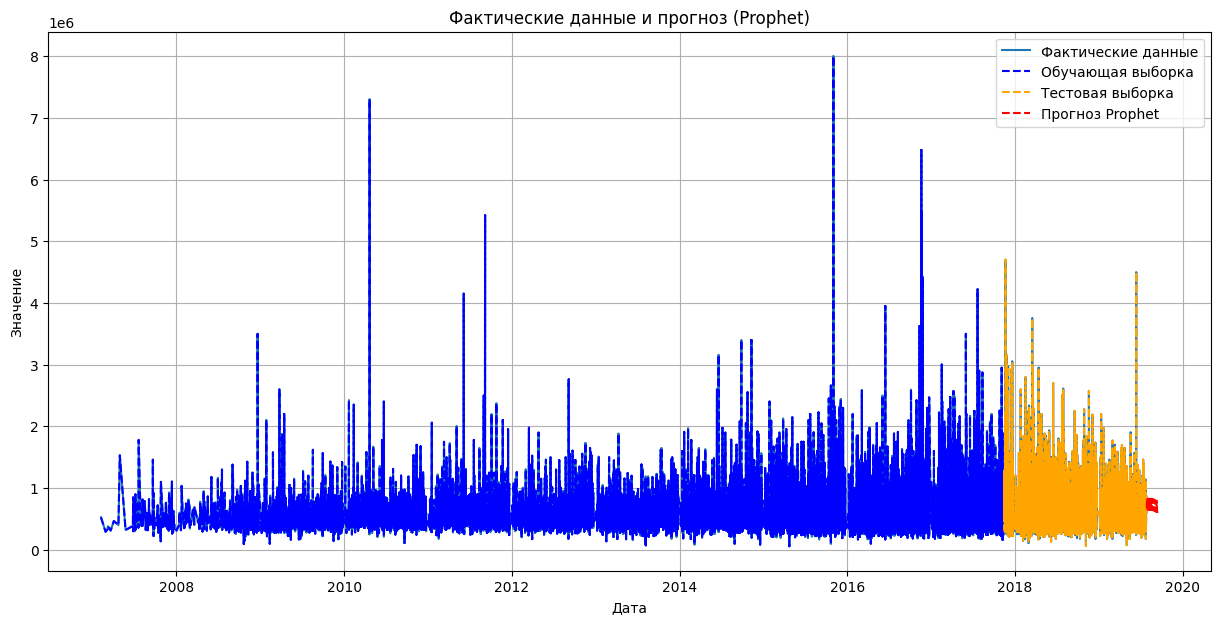


--- Пробуем ARIMA ---

--- Прогнозирование с использованием arima ---
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                23664
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -329907.590
Date:                Mon, 09 Jun 2025   AIC                         659827.179
Time:                        18:45:33   BIC                         659875.609
Sample:                             0   HQIC                        659842.896
                              - 23664                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6309      0.002   -317.213      0.000      -0.635      -0.627
ar.L2         -0.4535      0.004   -117.658      0.000      

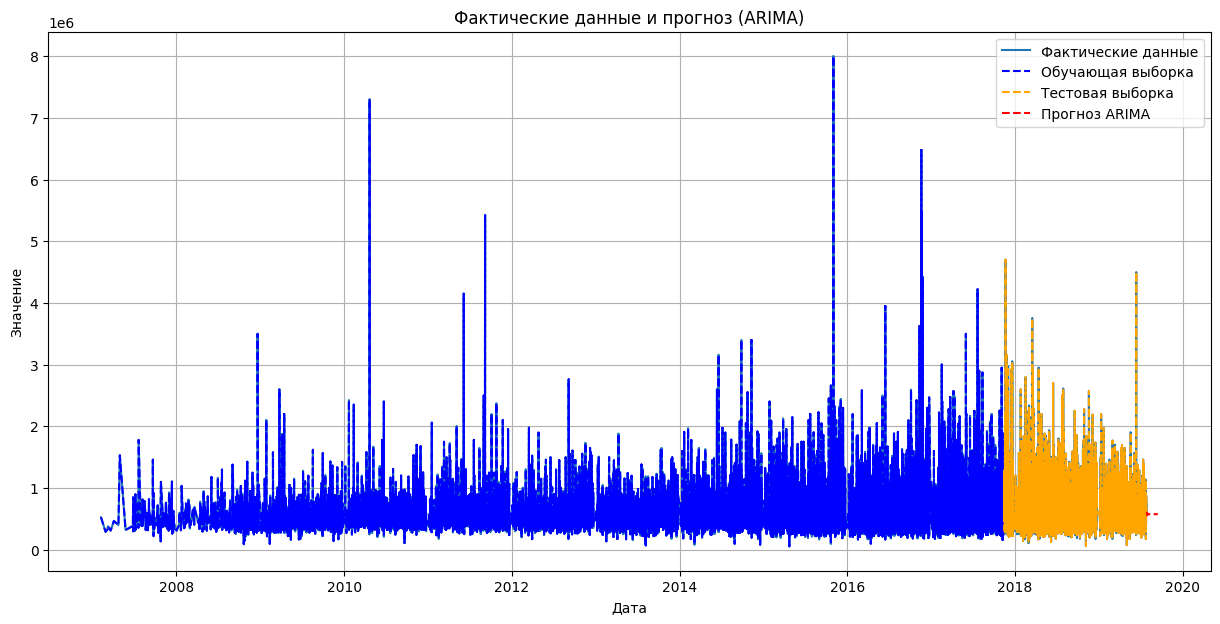


Прогнозирование завершено.


In [31]:
# --- Пример использования ---
if __name__ == "__main__":

    sample_df = pd.read_csv('/content/raw_sales.csv')[['datesold', 'price']]
    sample_df.to_csv("sample_time_series.csv", index=False)

    # Инициализация предсказателя
    predictor = TimeSeriesPredictor("sample_time_series.csv")

    # Загрузка данных
    # Если столбцы не определяются автоматически, укажите их:
    # predictor.load_data(time_column_name='Date', value_column_name='Value')
    predictor.load_data()

    # Визуализация исходного ряда
    predictor.plot_time_series("Исходный временной ряд")

    # Проверка на сезонность и тренд
    predictor.check_for_seasonality_and_trend()

    # --- Выбор и запуск модели ---
    forecast_horizon = 50 # Прогноз на 10 точек вперед

    # 1. Прогноз с помощью SARIMA (если есть сезонность)
    # Порядки (p,d,q) и (P,D,Q,S) определяются на основе ACF/PACF и разложения
    # Для примера: order=(1,1,1) (1 авторегрессия, 1 дифференциация, 1 скользящее среднее)
    # seasonal_order=(1,1,1,7) (1 сезонная авторегрессия, 1 сезонная дифференциация, 1 сезонное скользящее среднее, период 7)
    # Обратите внимание: seasonal_order=(1,1,1,X) где X - это период сезонности, который может быть определен в check_for_seasonality_and_trend
    if predictor.is_seasonal and predictor.seasonal_period:
        print(f"\n--- Пробуем SARIMA с периодом {predictor.seasonal_period} ---")
        sarima_forecast = predictor.train_and_predict(
            forecast_horizon=forecast_horizon,
            model_type="sarima",
            order=(1,1,1), # Примерные порядки
            seasonal_order=(1,1,1,predictor.seasonal_period) # Примерные порядки
        )
    else:
        print("\n--- Сезонность не обнаружена, SARIMA не будет использоваться ---")

    # 2. Прогноз с помощью Хольта-Уинтерса
    print("\n--- Пробуем Модель Хольта-Уинтерса ---")
    # Параметры trend и seasonal зависят от разложения
    # holtwinter_seasonal_period также будет браться из определенного или по умолчанию 12
    holt_winters_forecast = predictor.train_and_predict(
        forecast_horizon=forecast_horizon,
        model_type="holt_winters",
        holtwinter_trend='add', # 'add' или 'mul' или None
        holtwinter_seasonal='add', # 'add' или 'mul' или None
        holtwinter_seasonal_period=predictor.seasonal_period # Используем определенный период
    )

    # 3. Прогноз с помощью Prophet
    if Prophet:
        print("\n--- Пробуем Prophet ---")
        prophet_forecast = predictor.train_and_predict(
            forecast_horizon=forecast_horizon,
            model_type="prophet"
        )
    else:
        print("\n--- Prophet не установлен, прогноз с Prophet пропущен ---")

    # 4. Прогноз с помощью ARIMA (как базовый вариант, если нет сильной сезонности)
    # Это будет запускаться, если auto не выберет SARIMA
    print("\n--- Пробуем ARIMA ---")
    arima_forecast = predictor.train_and_predict(
        forecast_horizon=forecast_horizon,
        model_type="arima",
        order=(5,1,0) # Примерные порядки
    )

    print("\nПрогнозирование завершено.")